<a href="https://colab.research.google.com/github/Nishithmannuru/Nishith_INFO5731_Spring2022/blob/main/In_class_exercise_04_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **The fourth in-class-exercise (40 points in total, 03/29/2022)**

Question description: Please use the text corpus you collected in your last in-class-exercise for this exercise. Perform the following tasks:

## (1) (10 points) Generate K topics by using LDA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

In [ ]:
pip install pyLDAvis

     |████████████████████████████████| 1.7 MB 4.4 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=33983b2bf54b1d86c23139e5b750fe5c857375adbeedec25a9c9524c8a6271c6
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [ ]:
import re
import numpy as np
import pandas as pd
from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim_models  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

# Enable logging for gensim - optional
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.ERROR)

import warnings
warnings.filterwarnings("ignore",category=DeprecationWarning)

/usr/local/lib/python3.7/dist-packages/past/types/oldstr.py:5: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3,and in 3.9 it will stop working
  from collections import Iterable


In [ ]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [ ]:
df = pd.read_csv("Billgates_tweets.csv")

#Cleaning the data
import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

df["Text"] = df["Text"].apply(cleantext)

# Convert to list
data = df.Text.values.tolist()

In [ ]:
#Converting sentences to words
def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations

data_words = list(sent_to_words(data))

In [ ]:
# Build the bigram and trigram models
bigram = gensim.models.Phrases(data_words, min_count=5, threshold=100) # higher threshold fewer phrases.
trigram = gensim.models.Phrases(bigram[data_words], threshold=100)  

# Faster way to get a sentence clubbed as a trigram/bigram
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

# See trigram example
print(trigram_mod[bigram_mod[data_words[0]]])

/usr/local/lib/python3.7/dist-packages/gensim/models/phrases.py:598: UserWarning: For a faster implementation, use the gensim.models.phrases.Phraser class
  warnings.warn("For a faster implementation, use the gensim.models.phrases.Phraser class")


['optimistic', 'about', 'our', 'ability', 'to', 'prevent', 'the', 'next', 'pandemic', 'we', 'have', 'learned', 'so', 'much', 'from', 'covid', 'and', 'the', 'innovations', 'have', 'been', 'tremendous']


In [ ]:
# Define functions for stopwords, bigrams, trigrams and lemmatization
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [ ]:
# Remove Stop Words
data_words_nostops = remove_stopwords(data_words)

# Form Bigrams
data_words_bigrams = make_bigrams(data_words_nostops)

# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Do lemmatization keeping only noun, adj, vb, adv
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

print(data_lemmatized[:1])

[['optimistic', 'ability', 'prevent', 'next', 'pandemic', 'learn', 'much', 'covid', 'innovation', 'tremendous']]


In [ ]:
# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 1), (6, 1), (7, 1), (8, 1), (9, 1)]]


In [ ]:
# To see what word a given id corresponds to, pass the id as a key to the dictionary
id2word[0]

'ability'

In [ ]:
# Or, you can see a human-readable form of the corpus itself.
# Human readable format of corpus (term-frequency)
[[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]]

[[('ability', 1),
  ('covid', 1),
  ('innovation', 1),
  ('learn', 1),
  ('much', 1),
  ('next', 1),
  ('optimistic', 1),
  ('pandemic', 1),
  ('prevent', 1),
  ('tremendous', 1)]]

In [ ]:
# Build LDA model
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

In [ ]:
# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.053*"make" + 0.038*"world" + 0.026*"need" + 0.023*"progress" + '
  '0.021*"work" + 0.021*"way" + 0.019*"young" + 0.018*"investment" + '
  '0.018*"well" + 0.017*"important"'),
 (1,
  '0.048*"great" + 0.036*"help" + 0.028*"technology" + 0.025*"take" + '
  '0.020*"invest" + 0.020*"family" + 0.019*"create" + 0.019*"problem" + '
  '0.016*"support" + 0.016*"action"'),
 (2,
  '0.036*"energy" + 0.036*"talk" + 0.029*"new" + 0.023*"emission" + '
  '0.022*"climate_change" + 0.021*"ask" + 0.021*"challenge" + 0.020*"excited" '
  '+ 0.017*"avoid" + 0.017*"get"'),
 (3,
  '0.042*"thank" + 0.032*"inspire" + 0.029*"disease" + 0.029*"leader" + '
  '0.026*"help" + 0.024*"share" + 0.023*"live" + 0.023*"save" + 0.022*"fight" '
  '+ 0.021*"world"'),
 (4,
  '0.036*"today" + 0.029*"story" + 0.027*"country" + 0.022*"learn" + '
  '0.020*"love" + 0.019*"woman" + 0.018*"get" + 0.018*"child" + 0.018*"worker" '
  '+ 0.017*"bring"'),
 (5,
  '0.059*"could" + 0.026*"life" + 0.019*"remarkable" + 0.018*"case" +

In [ ]:
# Compute Perplexity
print('\nPerplexity: ', lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -7.423869100267821

Coherence Score:  0.37210532947820885


In [ ]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim_models.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.7/dist-packages/pyLDAvis/_prepare.py:247: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  by='saliency', ascending=False).head(R).drop('saliency', 1)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.285975 -0.040638       1        1  18.180312
9     -0.088794  0.087855       2        1  11.778260
3     -0.099968 -0.124893       3        1  11.201450
7     -0.034232  0.263263       4        1  10.912257
1      0.046487 -0.140963       5        1   9.415156
8      0.060030 -0.158706       6        1   9.252775
4      0.085261  0.075989       7        1   9.133447
2      0.219148  0.003581       8        1   9.077325
6      0.050755 -0.031541       9        1   5.941911
5      0.047286  0.066052      10        1   5.107107, topic_info=       Term        Freq       Total Category  logprob  loglift
18   health   80.000000   80.000000  Default  30.0000  30.0000
95     make  127.000000  127.000000  Default  29.0000  29.0000
17     good   63.000000   63.000000  Default  28.0000  28.0000
32   people  106.000000  106.000000  Default  27.0000  27.0000
396    book   63.000000   63.000000  Default  26.0000  26.0000
..      ...         ...         ...      ...      ...      ...
29     life   15.697854   65.032019  Topic10  -3.6573   1.5532
295   would   10.961280   35.076555  Topic10  -4.0165   1.8114
256     see    8.886415   62.133763  Topic10  -4.2263   1.0298
41     work    8.627387  118.632707  Topic10  -4.2559   0.3534
635  always    4.644177   15.553510  Topic10  -4.8752   1.7659

[441 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
352       2  0.876706   access
116       5  0.935453   action
998       6  0.807545  address
998      10  0.100943  address
325       3  0.914217  advance
...     ...       ...      ...
23        3  0.160353     year
23        4  0.531698     year
23        5  0.008440     year
2041      5  0.933699    yield
168       1  0.989574    young

[506 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 10, 4, 8, 2, 9, 5, 3, 7, 6])

In [ ]:
!wget http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
!unzip mallet-2.0.8.zip

mallet_path = "/content/mallet-2.0.8/bin/mallet"
ldamallet = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=20, id2word=id2word)

--2022-04-03 17:00:55--  http://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Resolving mallet.cs.umass.edu (mallet.cs.umass.edu)... 128.119.246.70
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:80... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip [following]
--2022-04-03 17:00:56--  https://mallet.cs.umass.edu/dist/mallet-2.0.8.zip
Connecting to mallet.cs.umass.edu (mallet.cs.umass.edu)|128.119.246.70|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16184794 (15M) [application/zip]
Saving to: ‘mallet-2.0.8.zip’

mallet-2.0.8.zip    100%[===================>]  15.43M  4.81MB/s    in 3.2s    

2022-04-03 17:01:00 (4.81 MB/s) - ‘mallet-2.0.8.zip’ saved [16184794/16184794]

Archive:  mallet-2.0.8.zip
   creating: mallet-2.0.8/
   creating: mallet-2.0.8/bin/
  inflating: mallet-2.0.8/bin/classifier2info  
  inflating: mallet-2.0.8/bin/csv2classify  
  inflating: mallet-2.

In [ ]:
# Show Topics
pprint(ldamallet.show_topics(formatted=False))

# Compute Coherence Score
coherence_model_ldamallet = CoherenceModel(model=ldamallet, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
coherence_ldamallet = coherence_model_ldamallet.get_coherence()
print('\nCoherence Score: ', coherence_ldamallet)

[(17,
  [('learn', 0.11180124223602485),
   ('inspire', 0.08902691511387163),
   ('work', 0.053830227743271224),
   ('woman', 0.039337474120082816),
   ('year', 0.037267080745341616),
   ('show', 0.037267080745341616),
   ('lesson', 0.033126293995859216),
   ('plan', 0.031055900621118012),
   ('hear', 0.026915113871635612),
   ('enjoy', 0.026915113871635612)]),
 (2,
  [('health', 0.17045454545454544),
   ('global', 0.12121212121212122),
   ('investment', 0.06060606060606061),
   ('build', 0.05113636363636364),
   ('good', 0.03787878787878788),
   ('worker', 0.03409090909090909),
   ('job', 0.032196969696969696),
   ('system', 0.030303030303030304),
   ('care', 0.026515151515151516),
   ('education', 0.026515151515151516)]),
 (18,
  [('make', 0.07835051546391752),
   ('big', 0.05567010309278351),
   ('world', 0.05567010309278351),
   ('question', 0.05360824742268041),
   ('tool', 0.04742268041237113),
   ('problem', 0.04536082474226804),
   ('meet', 0.032989690721649485),
   ('life', 0.

In [ ]:
#Finding the optimal number of topics

def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

In [ ]:
# Can take a long time to run.
model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_lemmatized, start=2, limit=40, step=2)

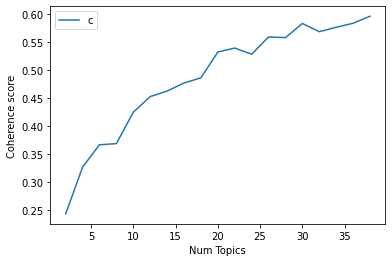

In [ ]:
# Show graph
limit=40; start=2; step=2;
x = range(start, limit, step)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [ ]:
# Print the coherence scores
for m, cv in zip(x, coherence_values):
    print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Coherence Value of 0.2424
Num Topics = 4  has Coherence Value of 0.3263
Num Topics = 6  has Coherence Value of 0.3663
Num Topics = 8  has Coherence Value of 0.3683
Num Topics = 10  has Coherence Value of 0.4246
Num Topics = 12  has Coherence Value of 0.4526
Num Topics = 14  has Coherence Value of 0.4625
Num Topics = 16  has Coherence Value of 0.4769
Num Topics = 18  has Coherence Value of 0.4862
Num Topics = 20  has Coherence Value of 0.5324
Num Topics = 22  has Coherence Value of 0.5394
Num Topics = 24  has Coherence Value of 0.5284
Num Topics = 26  has Coherence Value of 0.5594
Num Topics = 28  has Coherence Value of 0.5581
Num Topics = 30  has Coherence Value of 0.5835
Num Topics = 32  has Coherence Value of 0.5687
Num Topics = 34  has Coherence Value of 0.5767
Num Topics = 36  has Coherence Value of 0.5839
Num Topics = 38  has Coherence Value of 0.5964


In [ ]:
# I am considering 30 to be the ideal number of topics.
# Because the Coherence Values increased till number of topics = 30, then decreased and then continued to increase.
# And it is also appropriate to keep the number of topics as low as possible.
# Therefore finalizing "30" to be the ideal number of topics.

In [ ]:
# Select the model and print the topics
optimal_model = model_list[14]
#model_list[4] indicates that: model_list is a list that has been defined earlier and contains the number of topics and its coherence values.
# Since I have decided 10 to be the ideal number of topics, Topics number 30 is present in the 14th place of the list.
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=10))

[(0,
  '0.121*"important" + 0.076*"step" + 0.059*"close" + 0.051*"goal" + '
  '0.051*"excite" + 0.037*"bad" + 0.037*"part" + 0.034*"test" + '
  '0.034*"encourage" + 0.031*"slow"'),
 (9,
  '0.124*"today" + 0.095*"student" + 0.089*"support" + 0.080*"give" + '
  '0.055*"teacher" + 0.037*"organization" + 0.034*"turn" + 0.034*"school" + '
  '0.026*"project" + 0.017*"boost"'),
 (22,
  '0.091*"investment" + 0.085*"create" + 0.069*"build" + 0.055*"job" + '
  '0.047*"power" + 0.047*"ensure" + 0.036*"require" + 0.028*"path" + '
  '0.022*"infrastructure" + 0.022*"innovation"'),
 (16,
  '0.259*"country" + 0.078*"commitment" + 0.042*"month" + 0.039*"low" + '
  '0.024*"supply" + 0.024*"late" + 0.021*"gap" + 0.021*"large" + 0.021*"write" '
  '+ 0.021*"limit"'),
 (23,
  '0.172*"good" + 0.079*"start" + 0.076*"science" + 0.040*"kid" + '
  '0.040*"explain" + 0.036*"learn" + 0.033*"happen" + 0.030*"risk" + '
  '0.026*"mind" + 0.020*"eradication"'),
 (28,
  '0.233*"health" + 0.172*"global" + 0.091*"improve

# Topic summarization

Topic 0 - About the attitude required to succeed.

Topic 1 - Inspirational talk and their role plays.

Topic 2 - About when feeling loved and excited.

Topic 6 - About vaccinations and its effects.

Topic 7 - Specifing a particular event in an year.

Topic 8 - About the future and advancements that can take place.

Topic 9 - Schools, teachers and organizations.

Topic 12 - About scientists and their impressive works and achievements.

Topic 13 - Questions and answers about different topics through out history.

Topic 16 - About different countries and their commitments.

Topic 17 - About work.

Topic 18 - ABout life.

Topic 20 - About poverty.

Topic 21 - Critical health needs and their progress.

Topic 22 - About Infrastructures and Innovations.

Topic 23 - About education and learning.

Topic 24 - Technology and its innovations.

Topic 25 - About farmers and their hope.

Topic 26 - About the pandemic.

Topic 28 - About global health.


## (2) (10 points) Generate K topics by using LSA, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://www.datacamp.com/community/tutorials/discovering-hidden-topics-python

In [ ]:
# Write your code here


from gensim.models import LsiModel
LSAModel = LsiModel(corpus, 20, id2word)

In [ ]:
# defining compute for Coherence Values in LSI
def computeCoherenceValuesLSI(dictionary, doc_term_matrix, doc_clean, stop, start=2, step=3):
    coherence_values = []
    modelList = []
#providning start,stop and step
    for num_topics in range(start, stop, step):
        # generate LSA model
        LSAModel = LsiModel(doc_term_matrix, num_topics=20, id2word = dictionary)
        modelList.append(LSAModel)
        coherencemodel = CoherenceModel(model=LSAModel, texts=doc_clean, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return modelList, coherence_values

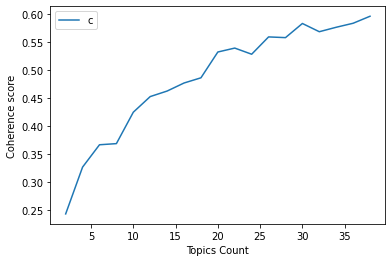

In [ ]:
# taking all the values from above and plotting a graph
start,stop,step=2,40,2
modelListLSA, coherenceValuesLSA = computeCoherenceValuesLSI(id2word, corpus,data_lemmatized,stop, start, step)
x = range(start, stop, step)
plt.plot(x, coherence_values)
# giving labels to axis
plt.xlabel("Topics Count")
plt.ylabel("Coherence score")
plt.legend(("conValues"), loc='best')
plt.show()

In [ ]:
# To get the topics count and the coherence values

for numberOfTopics, cv in zip(range(2, 40, 2), coherenceValuesLSA):
  print("Topics Count:", numberOfTopics, " - Coherence Value:", round(cv, 4))
#pprint(LSAModel.print_topics())

Topics Count: 2  - Coherence Value: 0.2402
Topics Count: 4  - Coherence Value: 0.2435
Topics Count: 6  - Coherence Value: 0.2572
Topics Count: 8  - Coherence Value: 0.2442
Topics Count: 10  - Coherence Value: 0.2456
Topics Count: 12  - Coherence Value: 0.2414
Topics Count: 14  - Coherence Value: 0.2546
Topics Count: 16  - Coherence Value: 0.2506
Topics Count: 18  - Coherence Value: 0.2442
Topics Count: 20  - Coherence Value: 0.242
Topics Count: 22  - Coherence Value: 0.2382
Topics Count: 24  - Coherence Value: 0.2295
Topics Count: 26  - Coherence Value: 0.25
Topics Count: 28  - Coherence Value: 0.2455
Topics Count: 30  - Coherence Value: 0.2451
Topics Count: 32  - Coherence Value: 0.2593
Topics Count: 34  - Coherence Value: 0.2373
Topics Count: 36  - Coherence Value: 0.2472
Topics Count: 38  - Coherence Value: 0.2651


In [ ]:
def prepare_corpus(doc_clean):
    """
    Input  : clean document
    Purpose: create term dictionary of our courpus and Converting list of documents (corpus) into Document Term Matrix
    Output : term dictionary and Document Term Matrix
    """
    # Creating the term dictionary of our courpus, where every unique term is assigned an index. dictionary = corpora.Dictionary(doc_clean)
    dictionary = corpora.Dictionary(doc_clean)
    # Converting list of documents (corpus) into Document Term Matrix using dictionary prepared above.
    doc_term_matrix = [dictionary.doc2bow(doc) for doc in doc_clean]
    # generate LDA model
    return dictionary,doc_term_matrix

In [ ]:
def create_gensim_lsa_model(doc_clean,number_of_topics,words):
    """
    Input  : clean document, number of topics and number of words associated with each topic
    Purpose: create LSA model using gensim
    Output : return LSA model
    """
    dictionary,doc_term_matrix=prepare_corpus(doc_clean)
    # generate LSA model
    lsamodel = LsiModel(doc_term_matrix, num_topics=number_of_topics, id2word = dictionary)  # train model
    print(lsamodel.print_topics(num_topics=number_of_topics, num_words=words))
    return lsamodel

In [ ]:
# LSA Model
number_of_topics=14
words=10
#document_list,titles=load_data("","articles.txt")
#clean_text=preprocess_data(document_list)
model=create_gensim_lsa_model(data_lemmatized,number_of_topics,words)
pprint(model.print_topics())

[(0, '-0.401*"world" + -0.281*"make" + -0.276*"work" + -0.232*"help" + -0.199*"year" + -0.195*"people" + -0.176*"need" + -0.156*"health" + -0.150*"country" + -0.125*"progress"'), (1, '0.618*"year" + -0.553*"world" + 0.192*"work" + -0.172*"help" + 0.137*"book" + -0.132*"need" + 0.114*"make" + 0.103*"lot" + 0.099*"last" + 0.087*"read"'), (2, '-0.363*"world" + -0.355*"make" + 0.348*"country" + 0.344*"health" + 0.326*"help" + -0.214*"year" + 0.200*"life" + 0.179*"vaccine" + 0.172*"global" + 0.160*"people"'), (3, '-0.590*"work" + 0.386*"make" + -0.322*"world" + 0.261*"need" + 0.147*"new" + 0.113*"progress" + 0.111*"pandemic" + 0.105*"country" + 0.104*"help" + 0.104*"take"'), (4, '0.413*"work" + -0.391*"people" + 0.306*"make" + -0.306*"help" + -0.260*"year" + 0.245*"health" + -0.214*"book" + -0.154*"world" + 0.115*"thank" + -0.114*"read"'), (5, '-0.373*"make" + 0.305*"need" + -0.275*"country" + -0.260*"people" + 0.239*"help" + 0.231*"work" + -0.231*"world" + 0.200*"new" + 0.181*"book" + -0.1

**SUMMARIZATION OF LSA TOPICS**

Topic 0 - About advancing the world and different countries improving its people progress.

Topic 1 - About different advancements every year.

Topic 2 - About countries and its people making world healthy and happy place to survive.

Topic 3 - About the world needing new ideologies to stop the pandemic.

Topic 4 - About how working people can help the world.

Topic 5 - About countries worrying about its people and employees health.

Topic 6 - About people staying safe during the crisis.

Topic 7 - About spreding the ideology of getting vaccinated.

Topic 8 - About vacinnations and how it helps peoples health.

Topic 9 - About the progress of the pandemic.

Topic 10 - About the pandemic and on how to fight through it.

Topic 11 - About books and their stories.

Topic 12 - About vacinnations to fight covid 19.

Topic 13 - About fighting for advancements in energy and its progress.

## (3) (10 points) Generate K topics by using  lda2vec, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here:

https://nbviewer.org/github/cemoody/lda2vec/blob/master/examples/twenty_newsgroups/lda2vec/lda2vec.ipynb

In [ ]:
# Write your code here





## (4) (10 points) Generate K topics by using BERTopic, the number of topics K should be decided by the coherence score, then summarize what are the topics. You may refer the code here: 

https://colab.research.google.com/drive/1FieRA9fLdkQEGDIMYl0I3MCjSUKVF8C-?usp=sharing

In [ ]:
# Write your code here

%%capture
!pip install bertopic

In [ ]:
import pandas as pd
data = pd.read_csv("Billgates_tweets.csv")

#Data cleaning

import re

def cleantext(tweets):
    text = re.sub(r'@[A-Za-z0-9_]+', '', tweets) #removes @mentions
    text = re.sub(r'#[A-Za-z0-9_]+', '', text) #removing Hashtag symbols.
    text = re.sub(r'RT[\s]+', '', text) #removing Retweet symbol (RT).
    text = re.sub(r'https?:\/\/\S+', '', text) #remove URL's.
    text = re.sub(r"www.\S+", "", text)
    text = re.sub('[()!?]', ' ', text)
    text = re.sub('\[.*?\]',' ', text)
    text = re.sub("[^A-Za-z0-9]"," ", text)#Filtering non-alphanumeric characters
    text = re.sub('\\n', '', text)#removing the '\n' character
    text = re.sub(r'[0-9]+', '', text)#removing numbers
    
    return text

data["Text"] = data["Text"].apply(cleantext)

#Converting the text into lower case
data['Text']=data["Text"].apply(lambda x: " ".join(x.lower() for x in x.split()))

#removing stop words
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
stop=stopwords.words('english')
data['Text']=data['Text'].apply(lambda x:" ".join(x for x in x.split() if x not in stop))


#Lemmatization
from textblob import Word
nltk.download('wordnet')
data['Text']=data['Text'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))

# Convert to list
docs = data.Text.values.tolist()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.


In [ ]:
from bertopic import BERTopic

topic_model = BERTopic(language="english", calculate_probabilities=True, verbose=True)
topics, probs = topic_model.fit_transform(docs)

Downloading:   0%|          | 0.00/1.18k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/10.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/612 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/116 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/39.3k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/349 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/350 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/13.2k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

2022-04-03 17:38:50,650 - BERTopic - Transformed documents to Embeddings
/usr/local/lib/python3.7/dist-packages/numba/np/ufunc/parallel.py:363: NumbaWarning: The TBB threading layer requires TBB version 2019.5 or later i.e., TBB_INTERFACE_VERSION >= 11005. Found TBB_INTERFACE_VERSION = 9107. The TBB threading layer is disabled.
  warnings.warn(problem)
2022-04-03 17:39:04,089 - BERTopic - Reduced dimensionality with UMAP
2022-04-03 17:39:04,204 - BERTopic - Clustered UMAP embeddings with HDBSCAN


In [ ]:
freq = topic_model.get_topic_info(); freq.head(5)

,Topic,Count,Name
0,-1,342,-1_health_world_pandemic_work
1,0,79,0_energy_climate_zero_clean
2,1,51,1_student_teacher_school_kid
3,2,51,2_health_child_foundation_birthday
4,3,50,3_vaccine_country_capacity_covid


In [ ]:
topic_model.get_topic(0)  # Select the most frequent topic

[('energy', 0.09063420484527249),
 ('climate', 0.05760184899859546),
 ('zero', 0.056553810368390287),
 ('clean', 0.048385165234611956),
 ('emission', 0.04818012894163612),
 ('net', 0.04360383645340258),
 ('change', 0.042635005008216896),
 ('need', 0.0403640890495749),
 ('economy', 0.03909287419309165),
 ('catalyst', 0.03656649442714538)]

In [ ]:
topic_model.visualize_topics()

In [ ]:
topic_model.visualize_distribution(probs[200], min_probability=0.015)

In [ ]:
topic_model.visualize_hierarchy(top_n_topics=50)

In [ ]:
topic_model.visualize_barchart(top_n_topics=5)

In [ ]:
topic_model.visualize_heatmap(n_clusters=20, width=1000, height=1000)

In [ ]:
topic_model.visualize_term_rank()

In [ ]:
topic_model.update_topics(docs, topics, n_gram_range=(1, 2))

In [ ]:
topic_model.get_topic(0)   # We select topic that we viewed before

[('energy', 0.05710364871501298),
 ('climate', 0.03909463450402819),
 ('zero', 0.035102663725226815),
 ('emission', 0.029509412373038457),
 ('clean', 0.029171717218640737),
 ('climate change', 0.0281829869078733),
 ('change', 0.0279817756524753),
 ('net', 0.02650701347568904),
 ('need', 0.02641083284427441),
 ('net zero', 0.02456407973571741)]

In [ ]:
new_topics, new_probs = topic_model.reduce_topics(docs, topics, probs, nr_topics=20)

2022-04-03 17:42:30,696 - BERTopic - Reduced number of topics from 22 to 21


In [ ]:
similar_topics, similarity = topic_model.find_topics("energy", top_n=5); similar_topics

[0, 2, -1, 10, 9]

In [ ]:
topic_model.get_topic(2)

[('health', 0.04394731789919312),
 ('child', 0.035206602437131154),
 ('foundation', 0.03161840160059507),
 ('work', 0.028405689548717288),
 ('birthday', 0.024758623768504157),
 ('global health', 0.021166592270571962),
 ('global', 0.020772896138255417),
 ('incredible', 0.019811486945103443),
 ('health education', 0.018802302093623616),
 ('world', 0.018746297764928727)]

## (5) (10 extra points) Compare the results generated by the four topic modeling algorithms, which one is better? You should explain the reasons in details.

Topic modeling can be assessed using the idea of Topic Coherence, because topic models can not guarantee that their output is interpretable. Topic modeling allows us to cut through the noise (deal with text data's high dimensionality) and identify the signal (the major subjects) in our data.

There are different techniques of Topic Modelling :
The most widely used among them are Latent Semantic Analysis(LSA) and Latent Dirichlet Allocation (LDA) .

LDA, or Latent Dirichlet Allocation, is the best and most often used approach for defining and working with Topic Modeling. It extracts topic probabilities from statistical data.

Latent Semantic Analysis :

The LSA employs the Bag of Words (BoW) model, which is supported by findings in a term-document matrix (occurrence of terms in a document).
Singular value decomposition is used by LSA to discover latent themes by performing a matrix decomposition on the document-term matrix.
The Topic coherence measure, which provides a realistic measure for identifying the number of topics, is the best technique to analyze and interpret k (number of topics) in topic modeling.
The average/median of pairwise word comparable scores of the words in a topic is used in the computation. The topic coherence score model has a high value.
The plot of coherence value vs. number of subjects illustrates that as the number of topics increases, the coherence score drops. The highest coherence score is determined by 14 topics, and the coherence value obtained for the data using the LDA algorithm is 0.25.

Latent Dirichlet Allocation : 

To extract topics from textual input, LDA is a frequently used topic modeling technique. Topic models learn topics—typically expressed as groups of important words—automatically and unsupervisedly from unlabeled documents. Subjects are not guaranteed to be well interpretable, hence coherence criteria have been developed to discern between good and bad topics. We built the necessary dictionaries and corpora for Topic Modeling: The dictionary and the corpus are the two basic inputs to the LDA topic model. Each word in the manuscript is assigned a unique id by Gensim.
We must also give the number of subjects in addition to the corpus and dictionary. LDA is an unsupervised approach, which means we don't know how many topics are in our corpus before we run the model. By experimenting with a small number of topics and comparing the results, we may use the LDA visualization tool pyLDAvis. One of the most used ways for estimating the number of subjects is topic coherence. We must create a number of LDA models with different numbers of topics (k) and choose the one with the highest coherence value. 
The plot of coherence value vs. number of topics demonstrates that as the number of topics increases, the coherence score declines, with a decline of 30. Because subjects with a coherence score of about 30 have strong coherence scores but may have repetitive keywords in the topic, the number of topics chosen is still dependent on the necessity.
Hence the data using the LDA technique has an observation coherence score of 0.58.

BerTopic:

BerTopic is a topic modeling technique that uses transformers (BERT embeddings) and class-based TF-IDF to create dense clusters. It also allows you to easily interpret and visualize the topics generated.

So, based on the aforementioned analysis, I can conclude that LDA (Latent Dirichlet Allocation) produces better outcomes with an optimum topic of 30. But probabliy BerTopic might be a better one due to the fact that its a latest model with more words in dictonary than any other model.